In [1]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import os
from torchvision import transforms
from torchvision.datasets import VisionDataset
from PIL import Image
import torch
from torch.utils.data import DataLoader
import numpy as np

import torchvision
import torch.nn as nn
import torch.optim as optim

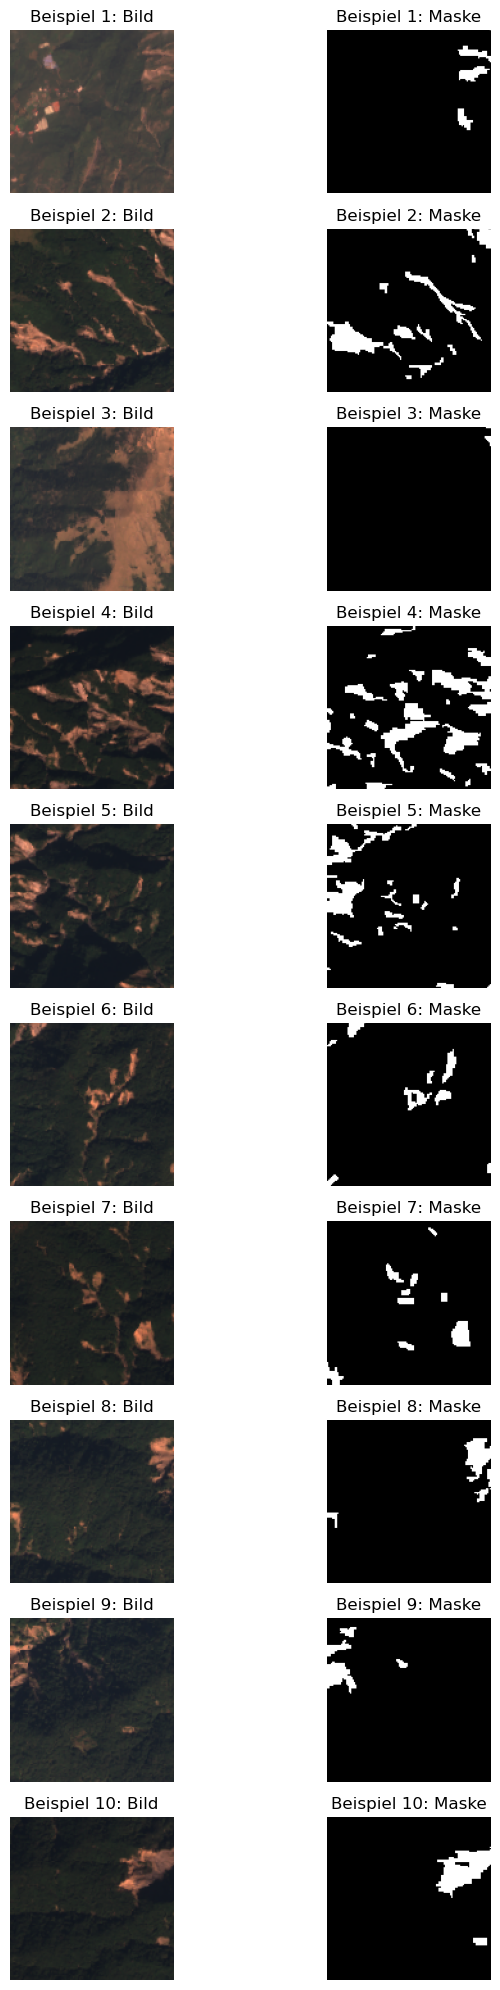

In [2]:
image_dir = 'data/train/images/'
mask_dir = 'data/train/masks/'

# Dateipfade für Bilder und Masken abrufen
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

# Sicherstellen, dass Bilder und Masken korrekt zugeordnet sind (z.B. durch gleiche Sortierung)
assert len(image_files) == len(mask_files)

fig, axs = plt.subplots(10, 2, figsize=(8, 20))  # 10 Reihen, 2 Spalten

for i in range(10):
    # Bild
    image = Image.open(image_files[i])
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Beispiel {i + 1}: Bild')

    # Maske
    mask = Image.open(mask_files[i]).convert('L')  # Konvertiere nach Graustufen für konsistente Darstellung
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Beispiel {i + 1}: Maske')

plt.tight_layout()
plt.show()

In [3]:
import os
from torchvision import transforms
from torchvision.datasets import VisionDataset
from PIL import Image
import torch
from torch.utils.data import DataLoader
import numpy as np

class SegmentationDataset(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(SegmentationDataset, self).__init__(root, transform=transform, target_transform=target_transform)
        
        assert split in ['train', 'test']
        self.split = split
        
        # Ordnerpfade für Bilder und Masken
        self.images_dir = os.path.join(root, split, 'images')
        self.masks_dir = os.path.join(root, split, 'masks')
        
        # Liste der Dateinamen
        self.images = sorted(os.listdir(self.images_dir))
        self.masks = sorted(os.listdir(self.masks_dir))
        
        assert len(self.images) == len(self.masks)

    def __getitem__(self, index):
        # Lade das Bild und die entsprechende Maske
        img_path = os.path.join(self.images_dir, self.images[index])
        mask_path = os.path.join(self.masks_dir, self.masks[index])
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert('1')
             
        # wende optional Transformationen an
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.images)

# Daten-Transformationen definieren
transform = transforms.Compose([
    transforms.Resize((256, 256)), # oder eine andere gewünschte Größe
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)), # muss dieselbe Größe wie das Bild haben
    transforms.ToTensor(),
])

# Datasets erstellen
train_data = SegmentationDataset(root="data", split="train", transform=transform, target_transform=mask_transform)
test_data = SegmentationDataset(root="data", split="test", transform=transform, target_transform=mask_transform)

# DataLoader erstellen
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [4]:
len(train_loader)

44

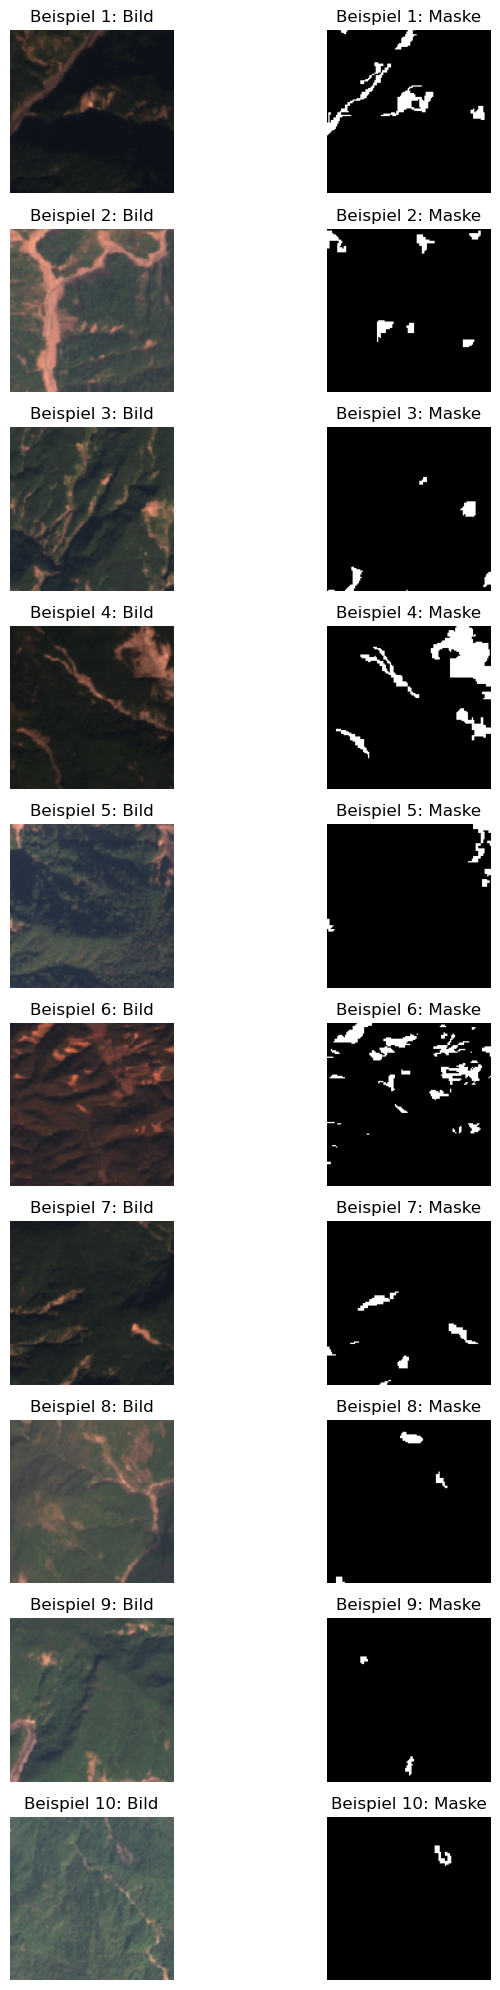

In [5]:
# Eine Charge von Daten aus dem DataLoader holen
images, masks = next(iter(train_loader))

fig, axs = plt.subplots(10, 2, figsize=(8, 20))  # 10 Reihen, 2 Spalten

for i in range(10):
    # Bild
    image = images[i].numpy().transpose((1, 2, 0))
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Beispiel {i + 1}: Bild')

    # Maske
    mask = masks[i][0].numpy()  # Beachte, dass wir nur den ersten Kanal für die Maske benötigen
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Beispiel {i + 1}: Maske')

plt.tight_layout()
plt.show()

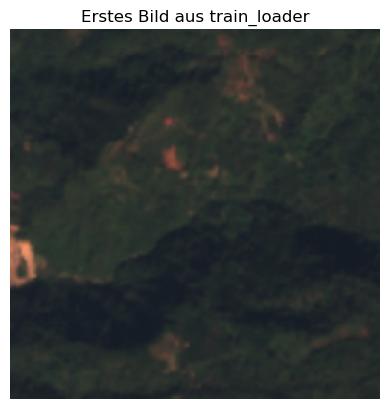

In [6]:
import matplotlib.pyplot as plt

# Eine Charge von Daten aus dem DataLoader holen
images, masks = next(iter(train_loader))

# Das erste Bild aus dieser Charge extrahieren und anzeigen
image = images[0].numpy().transpose((1, 2, 0))  # die Dimensionen ändern, um die Form (H, W, C) zu erhalten

plt.imshow(image)
plt.title('Erstes Bild aus train_loader')
plt.axis('off')
plt.show()


In [7]:
len(images)

32

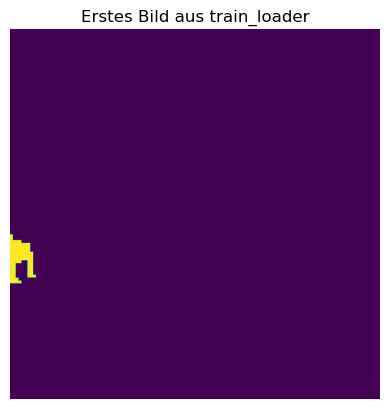

In [8]:
image = masks[0].numpy().transpose((1, 2, 0))  # die Dimensionen ändern, um die Form (H, W, C) zu erhalten

plt.imshow(image)
plt.title('Erstes Bild aus train_loader')
plt.axis('off')
plt.show()

In [9]:
images[0].shape

torch.Size([3, 256, 256])

In [10]:
masks[0].shape

torch.Size([1, 256, 256])

In [11]:
from PIL import Image
import numpy as np

# mask_path = "data/train/masks/mask_0.png"

mask_array = masks[0]

unique_values = np.unique(mask_array)
print("Eindeutige Werte in der Maske:", unique_values)

Eindeutige Werte in der Maske: [0. 1.]


In [12]:
value_counts = np.bincount(mask_array.flatten())
print("Verteilung der Werte:", value_counts)

Verteilung der Werte: [65196   340]


In [13]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cuda


In [14]:
# model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None,num_classes=1)
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None)

model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.squeeze(1)
        y = y.long()  

        # Compute prediction error
        pred = model(X)['out']
        loss = loss_fn(pred, y)
        train_loss += loss_fn(pred, y).item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches

    return train_loss

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.squeeze(1)
            y = y.long()  

            pred = model(X)['out']
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    return test_loss

In [17]:
def do_modeltrain(epochs, train_dataloader, model, loss_fn, optimizer, test_dataloader):
    for t in range(epochs):
        # accuracy_train, train_loss = train(train_dataloader, model, loss_fn, optimizer)
        # accuracy_test, test_loss = test(test_dataloader, model, loss_fn)
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        print("Training done")
        test_loss = test(test_dataloader, model, loss_fn)
        
        # Übermittlung der Daten an W&B
        # wandb.log({"accuracy train": accuracy_train, "loss train": train_loss, "accuracy test": accuracy_test, "loss test": test_loss})

        print("Train loss:", train_loss, "Test loss:", test_loss)

    print("Done!")

In [18]:
# Definition der Hyperparamter
no_epochs = 1
learn_rate = 0.1        # bestes Resultat @ 0.1
batchsize = 32          # bestes Resultat @ 128

# Definition vom config für den W&B run
# config = {
#   "epochs": no_epochs, 
#   "learn_rate": learn_rate, 
#   "batch_size": batchsize
# }


# Initialisierung des W&B run
# run = wandb.init(
#   project = project_name,
#   name = "Large Model Overfitting",
#   config = config
# )

# Erstellung der Batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

#Definition vom Modell
# model = LargeModel_oReg_oBN().to(device)    # bestes Model LargeModel_oReg_oBN
# wandb.watch(model, log= "parameters")
# print(model)

# Definition der Loss Metrik und vom Optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learn_rate)

# Ausführung des Trainings
do_modeltrain(no_epochs, train_loader, model, loss_fn, optimizer, test_loader)

# wandb.config["Model Name"] = model.__class__.__name__ 


# wandb.finish()

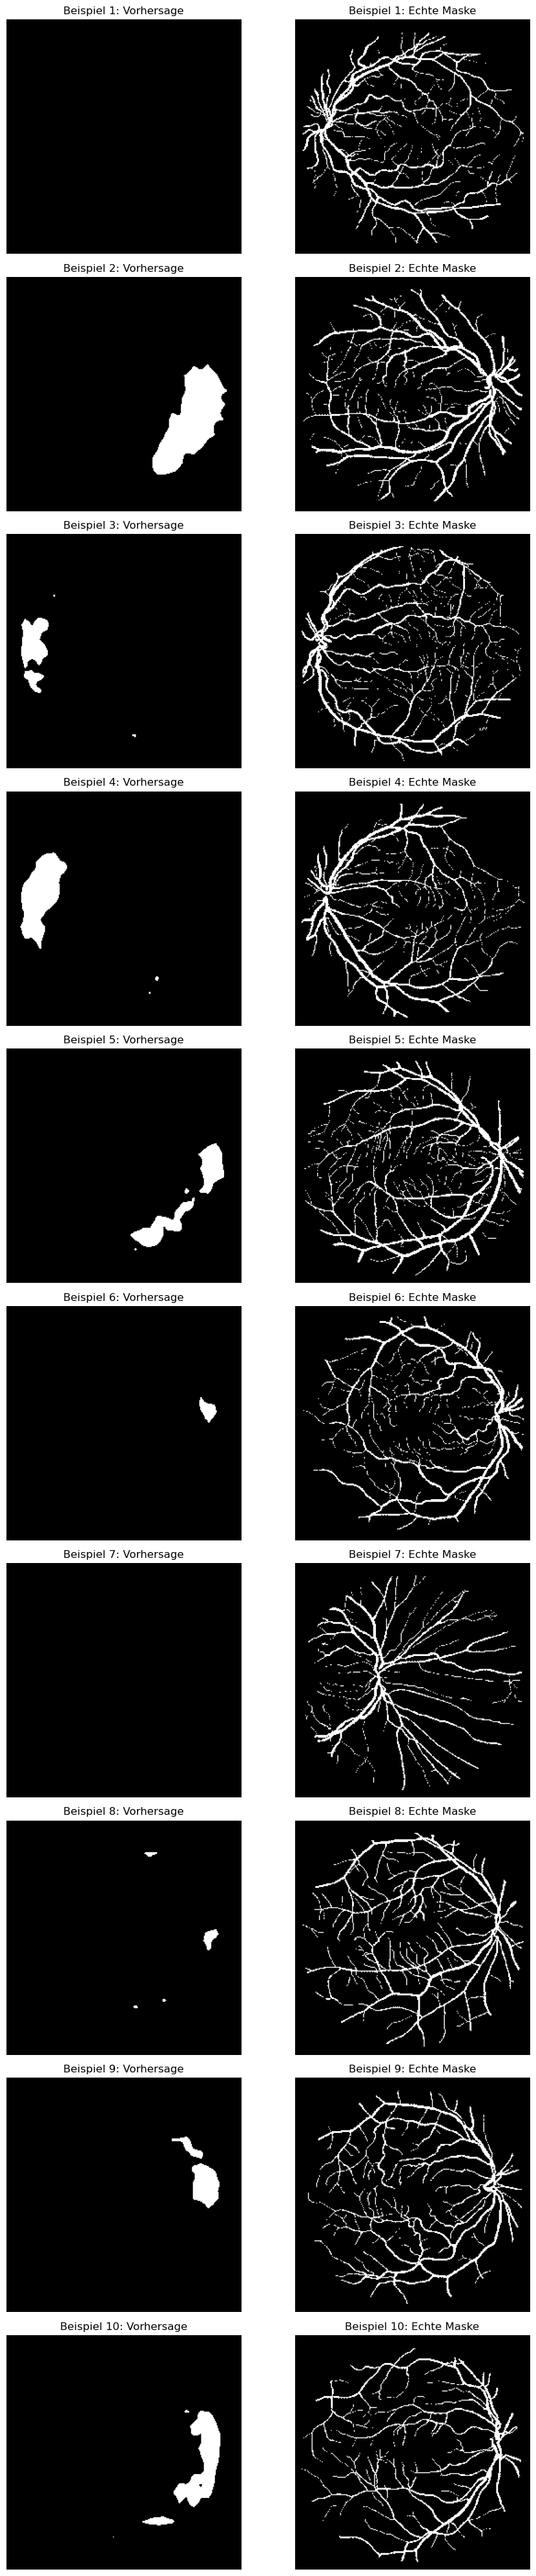

In [ ]:
# Angenommen, test_loader ist dein DataLoader für die Testdaten
test_images, test_masks = next(iter(test_loader))
test_images, test_masks = test_images.to(device), test_masks.to(device)

# Vorhersagen treffen
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    predictions = model(test_images)['out']
    _, preds = torch.max(predictions, dim=1)  # Finde die Klasse mit der höchsten Wahrscheinlichkeit

# Visualisiere die Vorhersagen neben den tatsächlichen Masken
fig, axs = plt.subplots(10, 2, figsize=(10, 40))  # 10 Reihen, 2 Spalten für 10 Bilder

for i in range(10):  # 10 Bilder
    axs[i, 0].imshow(preds[i].cpu(), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Beispiel {i + 1}: Vorhersage')

    axs[i, 1].imshow(test_masks[i].squeeze(0).cpu(), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Beispiel {i + 1}: Echte Maske')

plt.tight_layout()
plt.show()

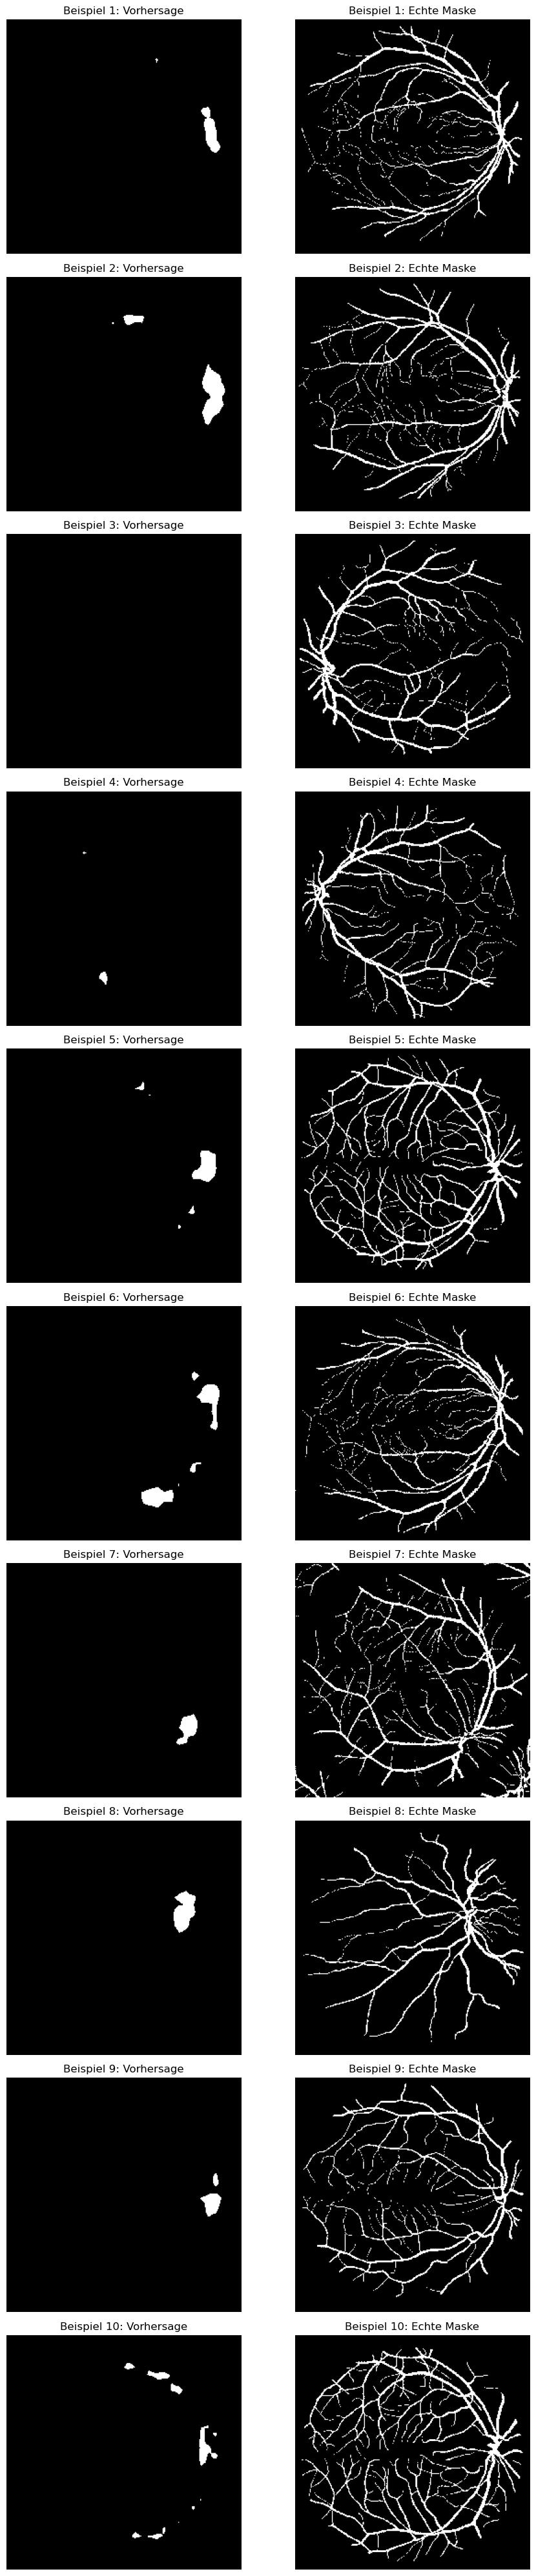

In [ ]:
# Angenommen, test_loader ist dein DataLoader für die Testdaten
train_images, train_masks = next(iter(train_loader))
train_images, train_masks = train_images.to(device), train_masks.to(device)

# Vorhersagen treffen
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    predictions = model(train_images)['out']
    _, preds = torch.max(predictions, dim=1)  # Finde die Klasse mit der höchsten Wahrscheinlichkeit

# Visualisiere die Vorhersagen neben den tatsächlichen Masken
fig, axs = plt.subplots(10, 2, figsize=(10, 40))  # 10 Reihen, 2 Spalten für 10 Bilder

for i in range(10):  # 10 Bilder
    axs[i, 0].imshow(preds[i].cpu(), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Beispiel {i + 1}: Vorhersage')

    axs[i, 1].imshow(train_masks[i].squeeze(0).cpu(), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Beispiel {i + 1}: Echte Maske')

plt.tight_layout()
plt.show()